In [1]:
%pylab inline
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.utils.np_utils import to_categorical

Using Theano backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
full_data = pd.read_csv('train.csv')
train_labels = full_data.species
train = full_data.drop(['species', 'id'], axis=1)

In [3]:
## Encoding the textual labels categorically and normalizing them such that 
## they contain only values between 0 and n_classes-1. 
label_encoder = LabelEncoder().fit(train_labels)
train_labels = label_encoder.transform(train_labels) 
num_classes = size(list(label_encoder.classes_))

In [4]:
## Standardising the data to give zero mean
## This seems to be very important
train = StandardScaler().fit(train).transform(train)

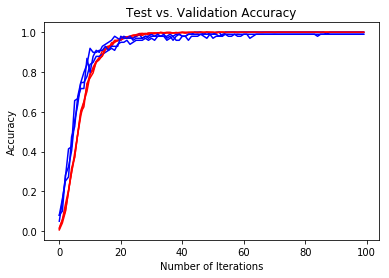

epoch   0 | train acc: 0.0168, train loss: 4.8136, val acc: 0.0808, val loss: 4.3698
epoch   5 | train acc: 0.3737, train loss: 3.2261, val acc: 0.5253, val loss: 2.7887
epoch  10 | train acc: 0.7845, train loss: 2.0957, val acc: 0.8384, val loss: 1.5821
epoch  15 | train acc: 0.9214, train loss: 1.2410, val acc: 0.8990, val loss: 0.8286
epoch  20 | train acc: 0.9618, train loss: 0.6833, val acc: 0.9495, val loss: 0.4229
epoch  25 | train acc: 0.9877, train loss: 0.3615, val acc: 0.9596, val loss: 0.2292
epoch  30 | train acc: 0.9966, train loss: 0.1889, val acc: 0.9697, val loss: 0.1441
epoch  35 | train acc: 0.9989, train loss: 0.0984, val acc: 0.9596, val loss: 0.1179
epoch  40 | train acc: 1.0000, train loss: 0.0509, val acc: 0.9798, val loss: 0.0649
epoch  45 | train acc: 1.0000, train loss: 0.0266, val acc: 0.9798, val loss: 0.0672
epoch  50 | train acc: 0.9989, train loss: 0.0151, val acc: 0.9697, val loss: 0.0687
epoch  55 | train acc: 0.9989, train loss: 0.0089, val acc: 0.979

In [5]:
val_acc_list = []
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=23)
for train_index, valid_index in sss.split(train, train_labels):
    
    X_train, X_valid = train[train_index], train[valid_index]
    y_train, y_valid = train_labels[train_index], train_labels[valid_index]
    
    ## Working with categorical crossentropy function, so converting the labels into "one-hot" representation
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    
    model = Sequential()
    model.add(Dense(1024,input_dim=X_train.shape[1])) # 192
    model.add(Dropout(0.2))
    model.add(Activation('sigmoid'))
    model.add(Dense(512))
    model.add(Dropout(0.3))
    model.add(Activation('sigmoid'))
    model.add(Dense(num_classes)) # 99
    model.add(Activation('softmax'))

    total_epochs = 100

    def print_results(epoch, logs):
        if epoch % 5 == 0 or epoch == total_epochs - 1:
            f = 'epoch {:3d} | train acc: {:.4f}, train loss: {:.4f}, val acc: {:.4f}, val loss: {:.4f}'
            print(f.format(epoch, logs['acc'], logs['loss'], logs['val_acc'], logs['val_loss']))

    cb = keras.callbacks.LambdaCallback(on_epoch_end=print_results)

    rms = keras.optimizers.RMSprop(lr=0.001)
    model.compile(loss='categorical_crossentropy',optimizer=rms, metrics=['accuracy'])
    history = model.fit(X_train, y_train, 
                        batch_size=128, 
                        nb_epoch=total_epochs, 
                        validation_data=(X_valid, y_valid), 
                        verbose=0, 
                        callbacks=[cb])
    val_acc = history.history['val_acc'][-1]
    val_acc_list.append(val_acc)
    print('Resulting Validation Accuracy: {:.4f}\n'.format(val_acc))
    
    plt.plot(history.history['acc'], 'r', history.history['val_acc'], 'b')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Accuracy')
    plt.title('Test vs. Validation Accuracy')
    
print('average accuracy: {:.4f}'.format(sum(val_acc_list) / float(len(val_acc_list))))

### TODO Use test set to get actual prediction